In [1]:
# IMPORT SOME MODULES =========================================================================
%pylab inline

from matplotlib.mlab import griddata
import pyfits as pyf
from PyTools import flux, nbins, err, binner, binned_stat, integrated_flux
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import leastsq
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product
from string import join
import paper_style, os

Populating the interactive namespace from numpy and matplotlib


In [2]:
# sizes ---------------------------------------------------------------------------------------
NR = 20
NRD = 10309
# labels --------------------------------------------------------------------------------------
par_lbs = dict(
    M=r"$M_\star$",
    log_t_M=r"$\left<\log{t_\star}\right>_M$",
    log_t_L=r"$\left<\log{t_\star}\right>_L$",
    log_Z_M=r"$\left<\log{Z_\star/Z\odot}\right>_M$",
    log_Z_L=r"$\left<\log{Z_\star/Z\odot}\right>_L$",
    Av=r"$A_V$"
)
res_lbs = dict(
    M=r"$\Delta\log{M_\star}$",
    log_t_M=r"$\Delta\left<\log{t_\star}\right>_M$",
    log_t_L=r"$\Delta\left<\log{t_\star}\right>_L$",
    log_Z_M=r"$\Delta\left<\log{Z_\star}\right>_M$",
    log_Z_L=r"$\Delta\left<\log{Z_\star}\right>_L$",
    Av=r"$\Delta A_V$"
)
con_lbs = dict(
    M=r"$\delta\log{M_\star}$",
    log_t_M=r"$\delta\left<\log{t_\star}\right>_M$",
    log_t_L=r"$\delta\left<\log{t_\star}\right>_L$",
    log_Z_M=r"$\delta\left<\log{Z_\star}\right>_M$",
    log_Z_L=r"$\delta\left<\log{Z_\star}\right>_L$",
    Av=r"$\delta A_V$"
)
tsize = "xx-small"

ssag_lb = r"\bf SSAG"
sdss_lb = r"\bf $ugriz$"
jpas_lb = r"\bf J-PAS"
spec_lb = r"\bf SPEC"

sfgs_lb = r"\bf SFGs"
pags_lb = r"\bf PaGs"
algs_lb = r"\bf All Galaxies"

# colors --------------------------------------------------------------------------------------
hatching = "/"*15
gray = "0.3"
ssag_cl = "0.2"
sdss_cl = "#F6C141"
sdss_sg = [sdss_cl, "#E8601C"]
jpas_cl = "#7BAFDE"
jpas_sg = [jpas_cl, "#1965B0"]
spec_cl = "#90C987"
spec_sg = [spec_cl, "#4EB265"]
col_map = cm.viridis

# output dir ----------------------------------------------------------------------------------
od = os.path.expandvars("$HOME/Documents/Publications/photofit_near_paper/")

In [3]:
ssag_tta = genfromtxt("../inputs/tta_cb13/ssag_catalog.log", dtype=None, names=True).repeat(NR)

lcolor = ssag_tta["u"]-ssag_tta["r"]
fields = [field.replace("lib", "mod") for field in ssag_tta.dtype.names if "_lib" in field]
kw = [field.rstrip("_mod") for field in fields[1:]]

sdss_tta = genfromtxt("../inputs/tta_cb13/outs/sdss/dynbas_output.log", dtype=None, names=True)
jpas_tta = genfromtxt("../inputs/tta_cb13/outs/jpas/dynbas_output.log", dtype=None, names=True)
spec_tta = genfromtxt("../inputs/tta_cb13/outs/spec/dynbas_output.log", dtype=None, names=True)

ssag_tta["M_lib"] = log10(ssag_tta["M_lib"])
sdss_tta["M_mod"] = log10(sdss_tta["M_mod"])
jpas_tta["M_mod"] = log10(jpas_tta["M_mod"])
spec_tta["M_mod"] = log10(spec_tta["M_mod"])

jpas_obs = zeros(NRD, dtype=zip(fields[1:], ["<f8"]*6))
spec_obs = copy(jpas_obs)
for m in fields[1:]:
    spec_obs[m] = loadtxt("data/PhotoNearAnalysis/SPEC_{}.txt".format(m))
    jpas_obs[m] = loadtxt("data/PhotoNearAnalysis/JPAS_{}.txt".format(m))

In [4]:
sdss_res = dict(
    M=err(ssag_tta["M_lib"], sdss_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], sdss_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], sdss_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], sdss_tta["Av_mod"], False)
)
jpas_res = dict(
    M=err(ssag_tta["M_lib"], jpas_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_tta["Av_mod"], False)
)
spec_res = dict(
    M=err(ssag_tta["M_lib"], spec_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_tta["Av_mod"], False)
)
tta_con = dict(
    [(kw[i], jpas_tta["{}_mod".format(kw[i])]-spec_tta["{}_mod".format(kw[i])]) for i in xrange(len(kw))]
)
obs_con = dict(
    [(kw[i], jpas_obs["{}_mod".format(kw[i])]-spec_obs["{}_mod".format(kw[i])]) for i in xrange(len(kw))]
)
ocolor = loadtxt("data/PhotoNearAnalysis/ur_color.txt")
pags = lcolor>2.22
sfgs = ~pags
algs = pags|sfgs

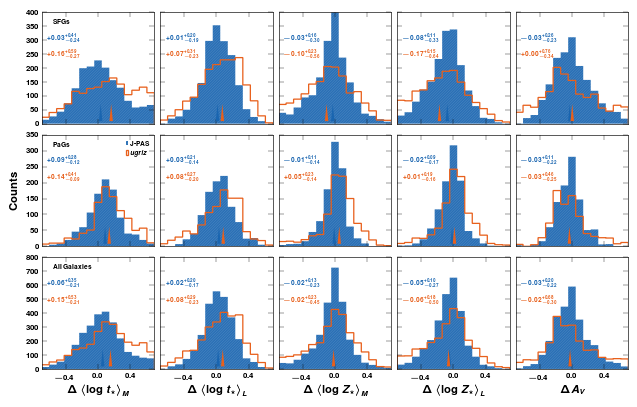

In [5]:
residual_h, residual_b = jpas_res, sdss_res
color_h, color_b = jpas_sg[1], sdss_sg[1]
label_h, label_b = jpas_lb, sdss_lb
sed_type_h, sed_type_b = "jpas", "sdss"
#--------------------------------------------------------------------------------

fig, axs = subplots(3, len(kw), figsize=(7, 4.5), sharex=True, sharey="row")

axs[1, 0].set_ylabel(r"\bf Counts")

lm = xlim(-0.7, +0.7)
axs[0, 0].set_xticks([-0.4, 0, 0.4])

for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    if i==0:
        mask = sfgs
    elif i==1:
        mask = pags
    else:
        mask = algs
        axs[i, j].set_xlabel(res_lbs[kw[j]])

    med_h = median(residual_h[kw[j]][mask])
    p16_h, p84_h = percentile(residual_h[kw[j]][mask], [16.0, 84.0])

    med_b = median(residual_b[kw[j]][mask])
    p16_b, p84_b = percentile(residual_b[kw[j]][mask], [16.0, 84.0])
    
    axs[i, j].hist(residual_h[kw[j]][mask], 15, range=lm, histtype="step", hatch=hatching, color=color_h, lw=0,
                   label=label_h)
    axs[i, j].hist(residual_b[kw[j]][mask], 15, range=lm, histtype="step", color=color_b, label=label_b)

    med_h_axes = axs[i, j].transAxes.inverted().transform(axs[i, j].transData.transform((med_h, 0.0)))+array([0,0.2])
    med_b_axes = axs[i, j].transAxes.inverted().transform(axs[i, j].transData.transform((med_b, 0.0)))+array([0,0.2])
    axs[i, j].annotate("", med_h_axes, (med_h,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":color_h,"ec":"none"})
    axs[i, j].annotate("", med_b_axes, (med_b,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":color_b,"ec":"none"})

    str_h = r"\bf $%+.2f_{%+.2f}^{%+.2f}$" % (med_h, p16_h, p84_h)
    str_b = r"\bf $%+.2f_{%+.2f}^{%+.2f}$" % (med_b, p16_b, p84_b)
    axs[i, j].text(0.05, 0.75, str_h, fontsize=tsize, color=color_h, ha="left", transform=axs[i, j].transAxes)
    axs[i, j].text(0.05, 0.60, str_b, fontsize=tsize, color=color_b, ha="left", transform=axs[i, j].transAxes)
    if j==0:
        if i==0: axs[i, j].text(0.1, 0.9, sfgs_lb, fontsize=tsize, ha="left", transform=axs[i, j].transAxes)
        if i==1: axs[i, j].text(0.1, 0.9, pags_lb, fontsize=tsize, ha="left", transform=axs[i, j].transAxes)
        if i==2: axs[i, j].text(0.1, 0.9, algs_lb, fontsize=tsize, ha="left", transform=axs[i, j].transAxes)

axs[1, 0].legend(loc=1, handlelength=0.3, handletextpad=0.3)

fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.05)

savefig("{}{}_vs_{}".format("img/", sed_type_h, sed_type_b))

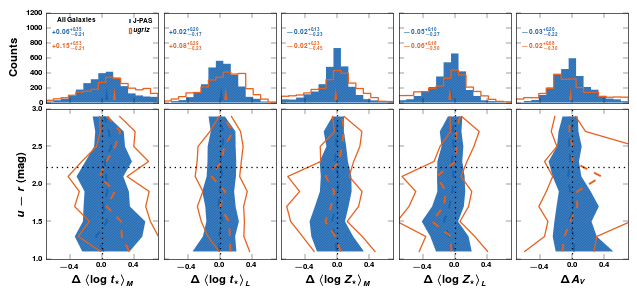

In [6]:
residual_h, residual_b = jpas_res, sdss_res
color_h, color_b = jpas_sg[1], sdss_sg[1]
label_h, label_b = jpas_lb, sdss_lb
sed_type_h, sed_type_b = "jpas", "sdss"
hist_ylm = 0, 1200
#--------------------------------------------------------------------------------

fig, axs = subplots(1, len(kw), figsize=(7, 3.3), sharex=True, sharey=True)

axr = []
for ax in axs:
    divider = make_axes_locatable(ax)
    axr.append(divider.append_axes("top", size="60%", pad=0.07, sharex=ax))
    axr[-1].set_ylim(hist_ylm)
    plt.setp(axr[-1].get_xticklabels()+([] if ax.is_first_col() else axr[-1].get_yticklabels()), visible=False)
axs = row_stack((axr, axs))

xlm = axs[0, 0].set_xlim(-0.7, +0.7)
ylm = axs[1, 0].set_ylim(1.0, 3.0)
axs[0, 0].set_xticks([-0.4, 0, 0.4])
axs[0, 0].set_ylabel(r"\bf Counts")
axs[1, 0].set_ylabel(r"\bf $u-r$ (mag)")

for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    if i==0:
        med_h = median(residual_h[kw[j]])
        p16_h, p84_h = percentile(residual_h[kw[j]], [16.0, 84.0])

        med_b = median(residual_b[kw[j]])
        p16_b, p84_b = percentile(residual_b[kw[j]], [16.0, 84.0])

        axs[i, j].hist(residual_h[kw[j]], 15, range=xlm, histtype="step", hatch=hatching, color=color_h, lw=0,
                       label=label_h)
        axs[i, j].hist(residual_b[kw[j]], 15, range=xlm, histtype="step", color=color_b, label=label_b)

        med_h_axes = axs[i, j].transAxes.inverted().transform(axs[i, j].transData.transform((med_h, 0.0)))+array([0,0.2])
        med_b_axes = axs[i, j].transAxes.inverted().transform(axs[i, j].transData.transform((med_b, 0.0)))+array([0,0.2])
        axs[i, j].annotate("", med_h_axes, (med_h,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":color_h,"ec":"none"})
        axs[i, j].annotate("", med_b_axes, (med_b,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":color_b,"ec":"none"})

        str_h = r"\bf $%+.2f_{%+.2f}^{%+.2f}$" % (med_h, p16_h, p84_h)
        str_b = r"\bf $%+.2f_{%+.2f}^{%+.2f}$" % (med_b, p16_b, p84_b)
        axs[i, j].text(0.05, 0.75, str_h, fontsize=tsize, color=color_h, ha="left", transform=axs[i, j].transAxes)
        axs[i, j].text(0.05, 0.60, str_b, fontsize=tsize, color=color_b, ha="left", transform=axs[i, j].transAxes)
    else:
        xh, yh, eh = binner(lcolor, residual_h[kw[j]], "median", 10, rang=ylm, ebar=True)
        xb, yb, eb = binner(lcolor, residual_b[kw[j]], "median", 10, rang=ylm, ebar=True)

        axs[i, j].plot(yh, xh, "--", color=color_h, lw=1.5)
        axs[i, j].fill_betweenx(xh, yh-eh[0], yh+eh[1], color=color_h, hatch=hatching, facecolor="none", lw=0)

        axs[i, j].plot(yb, xb, "--", color=color_b, lw=1.5)
        axs[i, j].plot(yb-eb[0], xb, "-", color=color_b, lw=1.0)
        axs[i, j].plot(yb+eb[1], xb, "-", color=color_b, lw=1.0)

        axs[i, j].axvline(ls=":", color="k")
        axs[i, j].axhline(2.22, ls=":", color="k")

        axs[i, j].set_xlabel(res_lbs[kw[j]])

axs[0, 0].text(0.1, 0.9, algs_lb, fontsize=tsize, ha="left", transform=axs[0, 0].transAxes)
axs[0, 0].legend(loc=1, handlelength=0.3, handletextpad=0.3)

fig.tight_layout()
fig.subplots_adjust(wspace=0.05)

savefig("{}{}_vs_{}".format("img/", sed_type_h, sed_type_b))

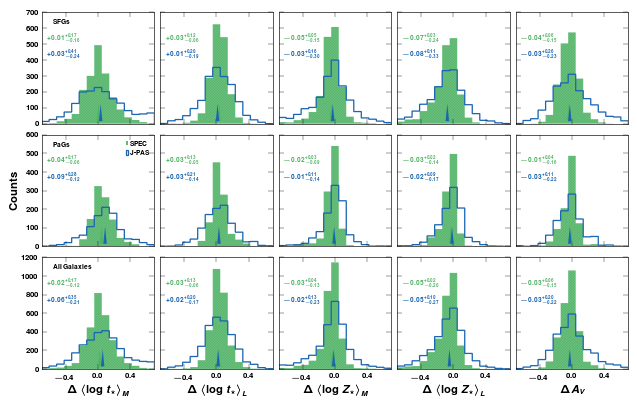

In [7]:
residual_h, residual_b = spec_res, jpas_res
color_h, color_b = spec_sg[1], jpas_sg[1]
label_h, label_b = spec_lb, jpas_lb
sed_type_h, sed_type_b = "spec", "jpas"
#--------------------------------------------------------------------------------

fig, axs = subplots(3, len(kw), figsize=(7, 4.5), sharex=True, sharey="row")

axs[1, 0].set_ylabel(r"\bf Counts")

lm = xlim(-0.7, +0.7)
axs[0, 0].set_xticks([-0.4, 0, 0.4])

for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    if i==0:
        mask = sfgs
    elif i==1:
        mask = pags
    else:
        mask = algs
        axs[i, j].set_xlabel(res_lbs[kw[j]])

    med_h = median(residual_h[kw[j]][mask])
    p16_h, p84_h = percentile(residual_h[kw[j]][mask], [16.0, 84.0])

    med_b = median(residual_b[kw[j]][mask])
    p16_b, p84_b = percentile(residual_b[kw[j]][mask], [16.0, 84.0])
    
    axs[i, j].hist(residual_h[kw[j]][mask], 15, range=lm, histtype="step", hatch=hatching, color=color_h, lw=0,
                   label=label_h)
    axs[i, j].hist(residual_b[kw[j]][mask], 15, range=lm, histtype="step", color=color_b, label=label_b)

    med_h_axes = axs[i, j].transAxes.inverted().transform(axs[i, j].transData.transform((med_h, 0.0)))+array([0,0.2])
    med_b_axes = axs[i, j].transAxes.inverted().transform(axs[i, j].transData.transform((med_b, 0.0)))+array([0,0.2])
    axs[i, j].annotate("", med_h_axes, (med_h,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":color_h,"ec":"none"})
    axs[i, j].annotate("", med_b_axes, (med_b,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":color_b,"ec":"none"})

    str_h = r"\bf $%+.2f_{%+.2f}^{%+.2f}$" % (med_h, p16_h, p84_h)
    str_b = r"\bf $%+.2f_{%+.2f}^{%+.2f}$" % (med_b, p16_b, p84_b)
    axs[i, j].text(0.05, 0.75, str_h, fontsize=tsize, color=color_h, ha="left", transform=axs[i, j].transAxes)
    axs[i, j].text(0.05, 0.60, str_b, fontsize=tsize, color=color_b, ha="left", transform=axs[i, j].transAxes)
    if j==0:
        if i==0: axs[i, j].text(0.1, 0.9, sfgs_lb, fontsize=tsize, ha="left", transform=axs[i, j].transAxes)
        if i==1: axs[i, j].text(0.1, 0.9, pags_lb, fontsize=tsize, ha="left", transform=axs[i, j].transAxes)
        if i==2: axs[i, j].text(0.1, 0.9, algs_lb, fontsize=tsize, ha="left", transform=axs[i, j].transAxes)

axs[1, 0].legend(loc=1, handlelength=0.3, handletextpad=0.3)

fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.05)

savefig("{}{}_vs_{}".format("img/", sed_type_h, sed_type_b))

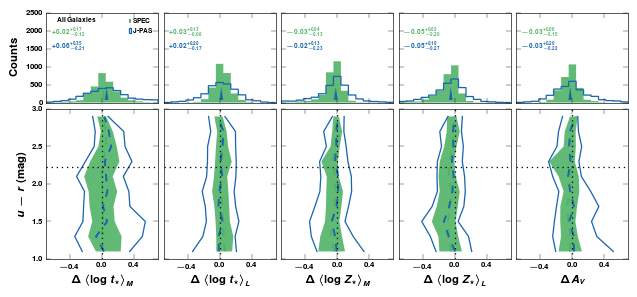

In [ ]:
residual_h, residual_b = spec_res, jpas_res
color_h, color_b = spec_sg[1], jpas_sg[1]
label_h, label_b = spec_lb, jpas_lb
sed_type_h, sed_type_b = "spec", "jpas"
hist_ylm = 0, 2500
#--------------------------------------------------------------------------------

fig, axs = subplots(1, len(kw), figsize=(7, 3.3), sharex=True, sharey=True)

axr = []
for ax in axs:
    divider = make_axes_locatable(ax)
    axr.append(divider.append_axes("top", size="60%", pad=0.07, sharex=ax))
    axr[-1].set_ylim(hist_ylm)
    plt.setp(axr[-1].get_xticklabels()+([] if ax.is_first_col() else axr[-1].get_yticklabels()), visible=False)
axs = row_stack((axr, axs))

xlm = axs[0, 0].set_xlim(-0.7, +0.7)
ylm = axs[1, 0].set_ylim(1.0, 3.0)
axs[0, 0].set_xticks([-0.4, 0, 0.4])
axs[0, 0].set_ylabel(r"\bf Counts")
axs[1, 0].set_ylabel(r"\bf $u-r$ (mag)")

for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    if i==0:
        med_h = median(residual_h[kw[j]])
        p16_h, p84_h = percentile(residual_h[kw[j]], [16.0, 84.0])

        med_b = median(residual_b[kw[j]])
        p16_b, p84_b = percentile(residual_b[kw[j]], [16.0, 84.0])

        axs[i, j].hist(residual_h[kw[j]], 15, range=xlm, histtype="step", hatch=hatching, color=color_h, lw=0,
                       label=label_h)
        axs[i, j].hist(residual_b[kw[j]], 15, range=xlm, histtype="step", color=color_b, label=label_b)

        med_h_axes = axs[i, j].transAxes.inverted().transform(axs[i, j].transData.transform((med_h, 0.0)))+array([0,0.2])
        med_b_axes = axs[i, j].transAxes.inverted().transform(axs[i, j].transData.transform((med_b, 0.0)))+array([0,0.2])
        axs[i, j].annotate("", med_h_axes, (med_h,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":color_h,"ec":"none"})
        axs[i, j].annotate("", med_b_axes, (med_b,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":color_b,"ec":"none"})

        str_h = r"\bf $%+.2f_{%+.2f}^{%+.2f}$" % (med_h, p16_h, p84_h)
        str_b = r"\bf $%+.2f_{%+.2f}^{%+.2f}$" % (med_b, p16_b, p84_b)
        axs[i, j].text(0.05, 0.75, str_h, fontsize=tsize, color=color_h, ha="left", transform=axs[i, j].transAxes)
        axs[i, j].text(0.05, 0.60, str_b, fontsize=tsize, color=color_b, ha="left", transform=axs[i, j].transAxes)
    else:
        xh, yh, eh = binner(lcolor, residual_h[kw[j]], "median", 10, rang=ylm, ebar=True)
        xb, yb, eb = binner(lcolor, residual_b[kw[j]], "median", 10, rang=ylm, ebar=True)

        axs[i, j].plot(yh, xh, "--", color=color_h, lw=1.5)
        axs[i, j].fill_betweenx(xh, yh-eh[0], yh+eh[1], color=color_h, hatch=hatching, facecolor="none", lw=0)

        axs[i, j].plot(yb, xb, "--", color=color_b, lw=1.5)
        axs[i, j].plot(yb-eb[0], xb, "-", color=color_b, lw=1.0)
        axs[i, j].plot(yb+eb[1], xb, "-", color=color_b, lw=1.0)

        axs[i, j].axvline(ls=":", color="k")
        axs[i, j].axhline(2.22, ls=":", color="k")

        axs[i, j].set_xlabel(res_lbs[kw[j]])

axs[0, 0].text(0.1, 0.9, algs_lb, fontsize=tsize, ha="left", transform=axs[0, 0].transAxes)
axs[0, 0].legend(loc=1, handlelength=0.3, handletextpad=0.3)

fig.tight_layout()
fig.subplots_adjust(wspace=0.05)

savefig("{}{}_vs_{}".format("img/", sed_type_h, sed_type_b))

\multirow{5}{*}{$\delta\left<\log{t_\star}\right>_M$} &      1.47 &     0.020 &     0.392 & &     0.033 &     0.369 \\
                         &      1.81 &     0.006 &     0.338 & &     0.019 &     0.400 \\
                         &      2.15 &     0.021 &     0.284 & &     0.021 &     0.327 \\
                         &      2.49 &     0.038 &     0.222 & &     0.048 &     0.131 \\
                         &      2.83 &     0.005 &     0.120 & &     0.056 &     0.093 \\
\hline
\multirow{5}{*}{$\delta\left<\log{t_\star}\right>_L$} &      1.47 &    -0.014 &     0.218 & &     0.146 &     0.380 \\
                         &      1.81 &    -0.024 &     0.215 & &     0.022 &     0.386 \\
                         &      2.15 &     0.001 &     0.179 & &    -0.035 &     0.325 \\
                         &      2.49 &     0.001 &     0.172 & &    -0.048 &     0.187 \\
                         &      2.83 &    -0.006 &     0.132 & &    -0.005 &     0.155 \\
\hline
\multirow{5}{*}{$\delta\left

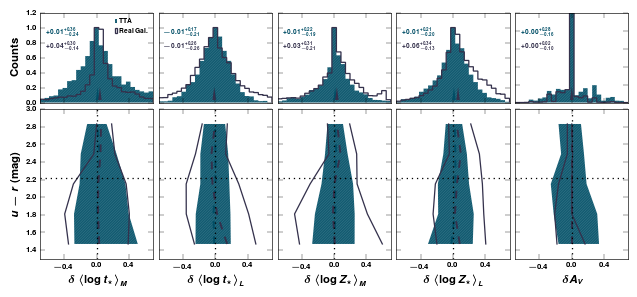

In [ ]:
residual_h, residual_b = tta_con, obs_con
color_h, color_b = "#004E66", "#34314C"
label_h, label_b = r"\bf TTA", r"\bf Real Gal."
sed_type_h, sed_type_b = "tta", "obs"
nb = 5
#--------------------------------------------------------------------------------

fig, axs = subplots(1, len(kw), figsize=(7, 3.3), sharex=True, sharey=True)

axr = []
for ax in axs:
    divider = make_axes_locatable(ax)
    axr.append(divider.append_axes("top", size="60%", pad=0.07, sharex=ax))
    plt.setp(axr[-1].get_xticklabels()+([] if ax.is_first_col() else axr[-1].get_yticklabels()), visible=False)
axs = row_stack((axr, axs))

xlm = axs[0, 0].set_xlim(-0.7, +0.7)
ylm = axs[1, 0].set_ylim(1.3, 3.0)
axs[0, 0].set_xticks([-0.4, 0, 0.4])
axs[0, 0].set_ylabel(r"\bf Counts")
axs[1, 0].set_ylabel(r"\bf $u-r$ (mag)")

for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    if i==0:
        med_h = median(residual_h[kw[j]])
        p16_h, p84_h = percentile(residual_h[kw[j]], [16.0, 84.0])

        med_b = median(residual_b[kw[j]])
        p16_b, p84_b = percentile(residual_b[kw[j]], [16.0, 84.0])

        N_h = histogram(residual_h[kw[j]], 25, range=xlm)[0].max().repeat(residual_h[kw[j]].size)
        N_b = histogram(residual_b[kw[j]], 25, range=xlm)[0].max().repeat(residual_b[kw[j]].size)
    
        axs[i, j].hist(residual_h[kw[j]], 25, range=xlm, weights=1.0/N_h, histtype="step", hatch=hatching, color=color_h, lw=0, label=label_h)
        axs[i, j].hist(residual_b[kw[j]], 25, range=xlm, weights=1.0/N_b, histtype="step", color=color_b, label=label_b)

        med_h_axes = axs[i, j].transAxes.inverted().transform(axs[i, j].transData.transform((med_h, 0.0)))+array([0,0.2])
        med_b_axes = axs[i, j].transAxes.inverted().transform(axs[i, j].transData.transform((med_b, 0.0)))+array([0,0.2])
        axs[i, j].annotate("", med_h_axes, (med_h,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":color_h,"ec":"none"})
        axs[i, j].annotate("", med_b_axes, (med_b,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":color_b,"ec":"none"})

        str_h = r"\bf $%+.2f_{%+.2f}^{%+.2f}$" % (med_h, p16_h, p84_h)
        str_b = r"\bf $%+.2f_{%+.2f}^{%+.2f}$" % (med_b, p16_b, p84_b)
        axs[i, j].text(0.05, 0.75, str_h, fontsize=tsize, color=color_h, ha="left", transform=axs[i, j].transAxes)
        axs[i, j].text(0.05, 0.60, str_b, fontsize=tsize, color=color_b, ha="left", transform=axs[i, j].transAxes)
    else:    
        xh, yh, eh = binner(lcolor, residual_h[kw[j]], "median", nb, rang=ylm, ebar=True)
        xb, yb, eb = binner(ocolor, residual_b[kw[j]], "median", nb, rang=ylm, ebar=True)

        axs[i, j].plot(yh, xh, "--", color=color_h, lw=1.5)
        axs[i, j].fill_betweenx(xh, yh-eh[0], yh+eh[1], color=color_h, hatch=hatching, facecolor="none", lw=0)

        axs[i, j].plot(yb, xb, "--", color=color_b, lw=1.5)
        axs[i, j].plot(yb-eb[0], xb, "-", color=color_b, lw=1.0)
        axs[i, j].plot(yb+eb[1], xb, "-", color=color_b, lw=1.0)

        axs[i, j].axvline(ls=":", color="k")
        axs[i, j].axhline(2.22, ls=":", color="k")

        axs[i, j].set_xlabel(con_lbs[kw[j]])

        for b in xrange(nb):
            if b == 0:
                print r"\multirow{5}{*}{%s} &%10.2f &%10.3f &%10.3f & &%10.3f &%10.3f \\" %\
                (con_lbs[kw[j]], xh[b], yh[b], (eh[1, b]+eh[0, b])*0.5, yb[b], (eb[1, b]+eb[0, b])*0.5)
            else:
                print r"                         &%10.2f &%10.3f &%10.3f & &%10.3f &%10.3f \\" %\
                (xb[b], yh[b], (eh[1, b]+eh[0, b])*0.5, yb[b], (eb[1, b]+eb[0, b])*0.5)
        print r"\hline"

axs[0, 0].legend(loc=1, handlelength=0.3, handletextpad=0.3)

fig.tight_layout()
fig.subplots_adjust(wspace=0.05)

savefig("{}{}_vs_{}".format(od, sed_type_h, sed_type_b))

In [ ]:
physical = sdss_tta
residual = sdss_res
label = sdss_lb
cl_sg = sdss_sg
sed_type = "sdss"
#--------------------------------------------------------------------------------

tm_true = ssag_tta["log_t_M_lib"]
tl_true = ssag_tta["log_t_L_lib"]
tm = physical["log_t_M_mod"]
tl = physical["log_t_L_mod"]
tm_mask = [
    [
        (residual["M"]<0.0)&(residual["log_t_M"]<0.0),
        (residual["M"]>=0.0)&(residual["log_t_M"]>=0.0)
    ],
    [
        (residual["log_Z_M"]>0.0)&(residual["log_t_M"]<0.0),
        (residual["log_Z_M"]<=0.0)&(residual["log_t_M"]>=0.0)
    ],
    [
        (residual["Av"]>0.0)&(residual["log_t_M"]<0.0),
        (residual["Av"]<=0.0)&(residual["log_t_M"]>=0.0)
    ],
]
tl_mask = [
    [
        (residual["M"]<0.0)&(residual["log_t_L"]<0.0),
        (residual["M"]>=0.0)&(residual["log_t_L"]>=0.0)
    ],
    [
        (residual["log_Z_L"]>0.0)&(residual["log_t_L"]<0.0),
        (residual["log_Z_L"]<=0.0)&(residual["log_t_L"]>=0.0)
    ],
    [
        (residual["Av"]>0.0)&(residual["log_t_L"]<0.0),
        (residual["Av"]<=0.0)&(residual["log_t_L"]>=0.0)
    ],
]
lg = [
    [
        r"$\Delta\log{M_\star}<0\,$",
        r"$\Delta\log{M_\star}\ge0\,$"
    ],
    [
        r"$\Delta\left<\log Z_\star\right>\ge0$",
        r"$\Delta\left<\log Z_\star\right><0$"
    ],
    [
        r"$\Delta A_V\ge0$",
        r"$\Delta A_V<0$"
    ]
]

fig, axs = subplots(3, 2, figsize=(3.3, 4.1), sharex=True, sharey=True)

lm = axs[0, 0].set_xlim(8, 10.5)
axs[-1, 0].set_ylim(0, 900)
axs[-1, 0].set_xlabel(par_lbs[kw[1]])
axs[-1, 1].set_xlabel(par_lbs[kw[2]])
axs[1, 0].set_ylabel(r"\bf Counts")
axs[0, 0].text(0.1, 0.85, join([label, sfgs_lb], ", "), fontsize=tsize, ha="left", transform=axs[0, 0].transAxes)
for i in xrange(axs.shape[0]):
    tm_sg = [tm[sfgs&tm_mask[i][0]], tm[sfgs&tm_mask[i][1]]]
    tl_sg = [tl[sfgs&tm_mask[i][0]], tl[sfgs&tm_mask[i][1]]]

    axs[i, 0].hist(tm[sfgs], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=lm)
    h = axs[i, 0].hist(tm_sg, 20, histtype="barstacked", color=cl_sg, ec="none", range=lm, rwidth=1)
    ps1, ps2 = h[-1]
    for p1, p2 in zip(ps1, ps2):
        p1.set_edgecolor(cl_sg[0])
        p2.set_edgecolor(cl_sg[1])
    axs[i, 0].hist(tm_true[sfgs], 20, histtype="step", ec=ssag_cl, range=lm, label=ssag_lb)

    axs[i, 1].hist(tl[sfgs], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=lm)
    h = axs[i, 1].hist(tl_sg, 20, histtype="barstacked", color=cl_sg, ec="none", range=lm, rwidth=1, label=lg[i])
    ps1, ps2 = h[-1]
    for p1, p2 in zip(ps1, ps2):
        p1.set_edgecolor(cl_sg[0])
        p2.set_edgecolor(cl_sg[1])
    if i==0:
        axs[i, 1].hist(tl_true[sfgs], 20, histtype="step", ec=ssag_cl, range=(8, 10.5), label=ssag_lb)
    else:
        axs[i, 1].hist(tl_true[sfgs], 20, histtype="step", ec=ssag_cl, range=(8, 10.5))
    axs[i, 1].legend(loc=2, handlelength=0.5, handletextpad=0.4)

tight_layout()
subplots_adjust(wspace=0.2, hspace=0.1)
savefig("{}age_vs_mass-metallicity-extinction_trends_{}_sfg".format(od, sed_type))
####################################################################################################################

fig, axs = subplots(3, 2, figsize=(3.3, 4.1), sharex=True, sharey=True)

lm = axs[0, 0].set_xlim(8, 10.5)
axs[-1, 0].set_ylim(0, 400)
axs[-1, 0].set_xlabel(par_lbs[kw[1]])
axs[-1, 1].set_xlabel(par_lbs[kw[2]])
axs[1, 0].set_ylabel(r"\bf Counts")
axs[0, 0].text(0.1, 0.85, join([label, pags_lb], ", "), fontsize=tsize, ha="left", transform=axs[0, 0].transAxes)
for i in xrange(axs.shape[0]):
    tm_sg = [tm[pags&tm_mask[i][0]], tm[pags&tm_mask[i][1]]]
    tl_sg = [tl[pags&tm_mask[i][0]], tl[pags&tm_mask[i][1]]]

    axs[i, 0].hist(tm[pags], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=lm)
    h = axs[i, 0].hist(tm_sg, 20, histtype="barstacked", color=cl_sg, ec="none", range=lm, rwidth=1)
    ps1, ps2 = h[-1]
    for p1, p2 in zip(ps1, ps2):
        p1.set_edgecolor(cl_sg[0])
        p2.set_edgecolor(cl_sg[1])
    axs[i, 0].hist(tm_true[pags], 20, histtype="step", ec=ssag_cl, range=lm, label=ssag_lb)

    axs[i, 1].hist(tl[pags], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=lm)
    h = axs[i, 1].hist(tl_sg, 20, histtype="barstacked", color=cl_sg, ec="none", range=lm, rwidth=1, label=lg[i])
    ps1, ps2 = h[-1]
    for p1, p2 in zip(ps1, ps2):
        p1.set_edgecolor(cl_sg[0])
        p2.set_edgecolor(cl_sg[1])
    if i==0:
        axs[i, 1].hist(tl_true[pags], 20, histtype="step", ec=ssag_cl, range=(8, 10.5), label=ssag_lb)
    else:
        axs[i, 1].hist(tl_true[pags], 20, histtype="step", ec=ssag_cl, range=(8, 10.5))
    axs[i, 1].legend(loc=2, handlelength=0.5, handletextpad=0.4)

tight_layout()
subplots_adjust(wspace=0.2, hspace=0.1)
savefig("{}age_vs_mass-metallicity-extinction_trends_{}_pag".format(od, sed_type))

In [ ]:
physical = jpas_tta
residual = jpas_res
label = jpas_lb
cl_sg = jpas_sg
sed_type = "jpas"
#--------------------------------------------------------------------------------

tm_true = ssag_tta["log_t_M_lib"]
tl_true = ssag_tta["log_t_L_lib"]
tm = physical["log_t_M_mod"]
tl = physical["log_t_L_mod"]
tm_mask = [
    [
        (residual["M"]<0.0)&(residual["log_t_M"]<0.0),
        (residual["M"]>=0.0)&(residual["log_t_M"]>=0.0)
    ],
    [
        (residual["log_Z_M"]>0.0)&(residual["log_t_M"]<0.0),
        (residual["log_Z_M"]<=0.0)&(residual["log_t_M"]>=0.0)
    ],
    [
        (residual["Av"]>0.0)&(residual["log_t_M"]<0.0),
        (residual["Av"]<=0.0)&(residual["log_t_M"]>=0.0)
    ],
]
tl_mask = [
    [
        (residual["M"]<0.0)&(residual["log_t_L"]<0.0),
        (residual["M"]>=0.0)&(residual["log_t_L"]>=0.0)
    ],
    [
        (residual["log_Z_L"]>0.0)&(residual["log_t_L"]<0.0),
        (residual["log_Z_L"]<=0.0)&(residual["log_t_L"]>=0.0)
    ],
    [
        (residual["Av"]>0.0)&(residual["log_t_L"]<0.0),
        (residual["Av"]<=0.0)&(residual["log_t_L"]>=0.0)
    ],
]
lg = [
    [
        r"$\Delta\log{M_\star}<0\,$",
        r"$\Delta\log{M_\star}\ge0\,$"
    ],
    [
        r"$\Delta\left<\log Z_\star\right>\ge0$",
        r"$\Delta\left<\log Z_\star\right><0$"
    ],
    [
        r"$\Delta A_V\ge0$",
        r"$\Delta A_V<0$"
    ]
]

fig, axs = subplots(3, 2, figsize=(3.3, 4.1), sharex=True, sharey=True)

lm = axs[0, 0].set_xlim(8, 10.5)
axs[-1, 0].set_ylim(0, 900)
axs[-1, 0].set_xlabel(par_lbs[kw[1]])
axs[-1, 1].set_xlabel(par_lbs[kw[2]])
axs[1, 0].set_ylabel(r"\bf Counts")
axs[0, 0].text(0.1, 0.85, join([label, sfgs_lb], ", "), fontsize=tsize, ha="left", transform=axs[0, 0].transAxes)
for i in xrange(axs.shape[0]):
    tm_sg = [tm[sfgs&tm_mask[i][0]], tm[sfgs&tm_mask[i][1]]]
    tl_sg = [tl[sfgs&tm_mask[i][0]], tl[sfgs&tm_mask[i][1]]]

    axs[i, 0].hist(tm[sfgs], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=lm)
    h = axs[i, 0].hist(tm_sg, 20, histtype="barstacked", color=cl_sg, ec="none", range=lm, rwidth=1)
    ps1, ps2 = h[-1]
    for p1, p2 in zip(ps1, ps2):
        p1.set_edgecolor(cl_sg[0])
        p2.set_edgecolor(cl_sg[1])
    axs[i, 0].hist(tm_true[sfgs], 20, histtype="step", ec=ssag_cl, range=lm, label=ssag_lb)

    axs[i, 1].hist(tl[sfgs], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=lm)
    h = axs[i, 1].hist(tl_sg, 20, histtype="barstacked", color=cl_sg, ec="none", range=lm, rwidth=1, label=lg[i])
    ps1, ps2 = h[-1]
    for p1, p2 in zip(ps1, ps2):
        p1.set_edgecolor(cl_sg[0])
        p2.set_edgecolor(cl_sg[1])
    if i==0:
        axs[i, 1].hist(tl_true[sfgs], 20, histtype="step", ec=ssag_cl, range=(8, 10.5), label=ssag_lb)
    else:
        axs[i, 1].hist(tl_true[sfgs], 20, histtype="step", ec=ssag_cl, range=(8, 10.5))
    axs[i, 1].legend(loc=2, handlelength=0.5, handletextpad=0.4)

tight_layout()
subplots_adjust(wspace=0.2, hspace=0.1)
savefig("{}age_vs_mass-metallicity-extinction_trends_{}_sfg".format(od, sed_type))
####################################################################################################################

fig, axs = subplots(3, 2, figsize=(3.3, 4.1), sharex=True, sharey=True)

lm = axs[0, 0].set_xlim(8, 10.5)
axs[-1, 0].set_ylim(0, 400)
axs[-1, 0].set_xlabel(par_lbs[kw[1]])
axs[-1, 1].set_xlabel(par_lbs[kw[2]])
axs[1, 0].set_ylabel(r"\bf Counts")
axs[0, 0].text(0.1, 0.85, join([label, pags_lb], ", "), fontsize=tsize, ha="left", transform=axs[0, 0].transAxes)
for i in xrange(axs.shape[0]):
    tm_sg = [tm[pags&tm_mask[i][0]], tm[pags&tm_mask[i][1]]]
    tl_sg = [tl[pags&tm_mask[i][0]], tl[pags&tm_mask[i][1]]]

    axs[i, 0].hist(tm[pags], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=lm)
    h = axs[i, 0].hist(tm_sg, 20, histtype="barstacked", color=cl_sg, ec="none", range=lm, rwidth=1)
    ps1, ps2 = h[-1]
    for p1, p2 in zip(ps1, ps2):
        p1.set_edgecolor(cl_sg[0])
        p2.set_edgecolor(cl_sg[1])
    axs[i, 0].hist(tm_true[pags], 20, histtype="step", ec=ssag_cl, range=lm, label=ssag_lb)

    axs[i, 1].hist(tl[pags], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=lm)
    h = axs[i, 1].hist(tl_sg, 20, histtype="barstacked", color=cl_sg, ec="none", range=lm, rwidth=1, label=lg[i])
    ps1, ps2 = h[-1]
    for p1, p2 in zip(ps1, ps2):
        p1.set_edgecolor(cl_sg[0])
        p2.set_edgecolor(cl_sg[1])
    if i==0:
        axs[i, 1].hist(tl_true[pags], 20, histtype="step", ec=ssag_cl, range=(8, 10.5), label=ssag_lb)
    else:
        axs[i, 1].hist(tl_true[pags], 20, histtype="step", ec=ssag_cl, range=(8, 10.5))
    axs[i, 1].legend(loc=2, handlelength=0.5, handletextpad=0.4)

tight_layout()
subplots_adjust(wspace=0.2, hspace=0.1)
savefig("{}age_vs_mass-metallicity-extinction_trends_{}_pag".format(od, sed_type))

In [ ]:
physical = spec_tta
residual = spec_res
label = spec_lb
cl_sg = spec_sg
sed_type = "spec"
#--------------------------------------------------------------------------------

tm_true = ssag_tta["log_t_M_lib"]
tl_true = ssag_tta["log_t_L_lib"]
tm = physical["log_t_M_mod"]
tl = physical["log_t_L_mod"]
tm_mask = [
    [
        (residual["M"]<0.0)&(residual["log_t_M"]<0.0),
        (residual["M"]>=0.0)&(residual["log_t_M"]>=0.0)
    ],
    [
        (residual["log_Z_M"]>0.0)&(residual["log_t_M"]<0.0),
        (residual["log_Z_M"]<=0.0)&(residual["log_t_M"]>=0.0)
    ],
    [
        (residual["Av"]>0.0)&(residual["log_t_M"]<0.0),
        (residual["Av"]<=0.0)&(residual["log_t_M"]>=0.0)
    ],
]
tl_mask = [
    [
        (residual["M"]<0.0)&(residual["log_t_L"]<0.0),
        (residual["M"]>=0.0)&(residual["log_t_L"]>=0.0)
    ],
    [
        (residual["log_Z_L"]>0.0)&(residual["log_t_L"]<0.0),
        (residual["log_Z_L"]<=0.0)&(residual["log_t_L"]>=0.0)
    ],
    [
        (residual["Av"]>0.0)&(residual["log_t_L"]<0.0),
        (residual["Av"]<=0.0)&(residual["log_t_L"]>=0.0)
    ],
]
lg = [
    [
        r"$\Delta\log{M_\star}<0\,$",
        r"$\Delta\log{M_\star}\ge0\,$"
    ],
    [
        r"$\Delta\left<\log Z_\star\right>\ge0$",
        r"$\Delta\left<\log Z_\star\right><0$"
    ],
    [
        r"$\Delta A_V\ge0$",
        r"$\Delta A_V<0$"
    ]
]

fig, axs = subplots(3, 2, figsize=(3.3, 4.1), sharex=True, sharey=True)

lm = axs[0, 0].set_xlim(8, 10.5)
axs[-1, 0].set_ylim(0, 900)
axs[-1, 0].set_xlabel(par_lbs[kw[1]])
axs[-1, 1].set_xlabel(par_lbs[kw[2]])
axs[1, 0].set_ylabel(r"\bf Counts")
axs[0, 0].text(0.1, 0.85, join([label, sfgs_lb], ", "), fontsize=tsize, ha="left", transform=axs[0, 0].transAxes)
for i in xrange(axs.shape[0]):
    tm_sg = [tm[sfgs&tm_mask[i][0]], tm[sfgs&tm_mask[i][1]]]
    tl_sg = [tl[sfgs&tm_mask[i][0]], tl[sfgs&tm_mask[i][1]]]

    axs[i, 0].hist(tm[sfgs], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=lm)
    h = axs[i, 0].hist(tm_sg, 20, histtype="barstacked", color=cl_sg, ec="none", range=lm, rwidth=1)
    ps1, ps2 = h[-1]
    for p1, p2 in zip(ps1, ps2):
        p1.set_edgecolor(cl_sg[0])
        p2.set_edgecolor(cl_sg[1])
    axs[i, 0].hist(tm_true[sfgs], 20, histtype="step", ec=ssag_cl, range=lm, label=ssag_lb)

    axs[i, 1].hist(tl[sfgs], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=lm)
    h = axs[i, 1].hist(tl_sg, 20, histtype="barstacked", color=cl_sg, ec="none", range=lm, rwidth=1, label=lg[i])
    ps1, ps2 = h[-1]
    for p1, p2 in zip(ps1, ps2):
        p1.set_edgecolor(cl_sg[0])
        p2.set_edgecolor(cl_sg[1])
    if i==0:
        axs[i, 1].hist(tl_true[sfgs], 20, histtype="step", ec=ssag_cl, range=(8, 10.5), label=ssag_lb)
    else:
        axs[i, 1].hist(tl_true[sfgs], 20, histtype="step", ec=ssag_cl, range=(8, 10.5))
    axs[i, 1].legend(loc=2, handlelength=0.5, handletextpad=0.4)

tight_layout()
subplots_adjust(wspace=0.2, hspace=0.1)
savefig("{}age_vs_mass-metallicity-extinction_trends_{}_sfg".format(od, sed_type))
####################################################################################################################

fig, axs = subplots(3, 2, figsize=(3.3, 4.1), sharex=True, sharey=True)

lm = axs[0, 0].set_xlim(8, 10.5)
axs[-1, 0].set_ylim(0, 400)
axs[-1, 0].set_xlabel(par_lbs[kw[1]])
axs[-1, 1].set_xlabel(par_lbs[kw[2]])
axs[1, 0].set_ylabel(r"\bf Counts")
axs[0, 0].text(0.1, 0.85, join([label, pags_lb], ", "), fontsize=tsize, ha="left", transform=axs[0, 0].transAxes)
for i in xrange(axs.shape[0]):
    tm_sg = [tm[pags&tm_mask[i][0]], tm[pags&tm_mask[i][1]]]
    tl_sg = [tl[pags&tm_mask[i][0]], tl[pags&tm_mask[i][1]]]

    axs[i, 0].hist(tm[pags], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=lm)
    h = axs[i, 0].hist(tm_sg, 20, histtype="barstacked", color=cl_sg, ec="none", range=lm, rwidth=1)
    ps1, ps2 = h[-1]
    for p1, p2 in zip(ps1, ps2):
        p1.set_edgecolor(cl_sg[0])
        p2.set_edgecolor(cl_sg[1])
    axs[i, 0].hist(tm_true[pags], 20, histtype="step", ec=ssag_cl, range=lm, label=ssag_lb)

    axs[i, 1].hist(tl[pags], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=lm)
    h = axs[i, 1].hist(tl_sg, 20, histtype="barstacked", color=cl_sg, ec="none", range=lm, rwidth=1, label=lg[i])
    ps1, ps2 = h[-1]
    for p1, p2 in zip(ps1, ps2):
        p1.set_edgecolor(cl_sg[0])
        p2.set_edgecolor(cl_sg[1])
    if i==0:
        axs[i, 1].hist(tl_true[pags], 20, histtype="step", ec=ssag_cl, range=(8, 10.5), label=ssag_lb)
    else:
        axs[i, 1].hist(tl_true[pags], 20, histtype="step", ec=ssag_cl, range=(8, 10.5))
    axs[i, 1].legend(loc=2, handlelength=0.5, handletextpad=0.4)

tight_layout()
subplots_adjust(wspace=0.2, hspace=0.1)
savefig("{}age_vs_mass-metallicity-extinction_trends_{}_pag".format(od, sed_type))

In [ ]:
residuals = sdss_res, jpas_res
labels = sdss_lb, jpas_lb
masks = sfgs, pags
texts = sfgs_lb, pags_lb
x, y, z = "Av log_t_M log_Z_M".split()
lm = -1.3, +1.3
lmz = -0.5, +0.5
name = "age-extinction-metallicity_mw_trends"
#-----------------------------------------------------------------------------------------------------
fig = figure(figsize=(3.3, 3.3))

ax11 = subplot2grid((20, 21), (0, 0), rowspan=10, colspan=10, xticklabels=[], xlim=lm, ylim=lm)
ax21 = subplot2grid((20, 21), (10, 0), rowspan=10, colspan=10, xlabel=res_lbs[x], xlim=lm, ylim=lm)
ax12 = subplot2grid((20, 21), (0, 10), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=lm, ylim=lm)
ax22 = subplot2grid((20, 21), (10, 10), rowspan=10, colspan=10, xlabel=res_lbs[x], yticklabels=[], xlim=lm, ylim=lm)

axs = array([[ax11, ax12], [ax21, ax22]])
axc = subplot2grid((20, 21), (1, 20), rowspan=18)

fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.4)


xe = ye = linspace(lm[0], lm[1], 26)
for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    mask = (masks[0] if i==0 else masks[1])
    res = (residuals[0] if j==0 else residuals[1])
    lbs = "{}, {}".format((labels[0] if j==0 else labels[1]), (texts[0] if i==0 else texts[1]))

    H, xe, ye = histogram2d(res[x][mask], res[y][mask], bins=[25, 25], range=[lm, lm], normed=True)
    H = gaussian_filter(H, sigma=1)
    cont = axs[i, j].contour(xe[:- 1], ye[:- 1], H.T, [0, 0.5, 2], colors="r", linewidths=0.5)
    clabel(cont, fontsize=5, fmt=r"\bf %.1f", color="r", inline=True)
     
    Z = griddata(res[x][mask], res[y][mask], res[z][mask], xe[:-1], ye[:-1], interp="linear")
    ct = axs[i, j].pcolormesh(xe[:-1], ye[:-1], Z, vmin=lmz[0], vmax=lmz[1], cmap=col_map, edgecolor="face")
    axs[i, j].axvline(ls=":", color="r", lw=0.5)
    axs[i, j].axhline(ls=":", color="r", lw=0.5)

    axs[i, j].text(0.05, 0.05, lbs, size=tsize, ha="left", va="bottom", transform=axs[i, j].transAxes)
    if axs[i, j].is_last_row(): axs[i, j].set_xlabel(res_lbs[x])
    if axs[i, j].is_first_col(): axs[i, j].set_ylabel(res_lbs[y])

cb = colorbar(ct, cax=axc)
cb.set_label(res_lbs[z])

#savefig("{}{}".format(od, name))

In [ ]:
residuals = sdss_res, jpas_res
labels = sdss_lb, jpas_lb
masks = sfgs, pags
texts = sfgs_lb, pags_lb
x, y, z = "Av log_t_M log_Z_M".split()
lm = -1.3, +1.3
name = "age-extinction-metallicity_mw_trends"
#-----------------------------------------------------------------------------------------------------
fig = figure(figsize=(3.3, 4))

ax11 = subplot2grid((30, 21), (0, 0), rowspan=10, colspan=10, xticklabels=[], xlim=lm, ylim=lm)
ax21 = subplot2grid((30, 21), (10, 0), rowspan=10, colspan=10, xticklabels=[], xlim=lm, ylim=lm)
ax31 = subplot2grid((30, 21), (20, 0), rowspan=10, colspan=10, xlabel=res_lbs[x], xlim=lm, ylim=lm)
ax12 = subplot2grid((30, 21), (0, 10), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=lm, ylim=lm)
ax22 = subplot2grid((30, 21), (10, 10), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=lm, ylim=lm)
ax32 = subplot2grid((30, 21), (20, 10), rowspan=10, colspan=10, xlabel=res_lbs[x], yticklabels=[], xlim=lm, ylim=lm)

axs = array([[ax11, ax12], [ax21, ax22], [ax31, ax32]])
ac1 = subplot2grid((30, 21), (1, 20), rowspan=8)
ac2 = subplot2grid((30, 21), (11, 20), rowspan=18)

fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

axs[1, 0].set_ylabel(res_lbs[y])

for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    mask = (masks[0] if i==1 else masks[1])
    res = (residuals[0] if j==0 else residuals[1])
    lbs = "{}, {}".format((labels[0] if j==0 else labels[1]), (texts[0] if i==1 else texts[1]))
    
    if i==0:
        H, xe, ye = histogram2d(res[x][mask], res[y][mask], bins=(25, 25), range=(lm, lm))
        ht = axs[i, j].pcolormesh(xe[:-1], ye[:-1], H.T, cmap=col_map, edgecolor="face")
        axs[i, j].axvline(ls=":", color="r", lw=0.5)
        axs[i, j].axhline(ls=":", color="r", lw=0.5)
    else:
        H, xe, ye = histogram2d(res[x][mask], res[y][mask], bins=[25, 25], range=[lm, lm], normed=True)
        H = gaussian_filter(H, sigma=1)
        cont = axs[i, j].contour(xe[:- 1], ye[:- 1], H.T, [0, 0.5, 2], colors="r", linewidths=0.5)
        clabel(cont, fontsize=5, fmt=r"\bf %.1f", color="r", inline=True)
 
        Z = griddata(res[x][mask], res[y][mask], res[z][mask], xe[:-1], ye[:-1], interp="linear")
        ct = axs[i, j].pcolormesh(xe[:-1], ye[:-1], Z, vmin=-0.5, vmax=+0.5, cmap=col_map, edgecolor="face")
        axs[i, j].axvline(ls=":", color="r", lw=0.5)
        axs[i, j].axhline(ls=":", color="r", lw=0.5)

        axs[i, j].text(0.05, 0.05, lbs, size=tsize, ha="left", va="bottom", transform=axs[i, j].transAxes)

cb1 = colorbar(ht, cax=ac1)
cb1.set_label(r"\bf No. Galaxies")
cb2 = colorbar(ct, cax=ac2)
cb2.set_label(res_lbs[z])

#savefig("{}{}_density".format(od, name))

In [ ]:
residuals = sdss_res, jpas_res
labels = sdss_lb, jpas_lb
masks = sfgs, pags
texts = sfgs_lb, pags_lb
x, y, z = "Av log_t_L log_Z_L".split()
lm = -1.3, +1.3
lmz = -0.5, +0.5
name = "age-extinction-metallicity_lw_trends"
#-----------------------------------------------------------------------------------------------------
fig = figure(figsize=(3.3, 3.3))

ax11 = subplot2grid((20, 21), (0, 0), rowspan=10, colspan=10, xticklabels=[], xlim=lm, ylim=lm)
ax21 = subplot2grid((20, 21), (10, 0), rowspan=10, colspan=10, xlabel=res_lbs[x], xlim=lm, ylim=lm)
ax12 = subplot2grid((20, 21), (0, 10), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=lm, ylim=lm)
ax22 = subplot2grid((20, 21), (10, 10), rowspan=10, colspan=10, xlabel=res_lbs[x], yticklabels=[], xlim=lm, ylim=lm)

axs = array([[ax11, ax12], [ax21, ax22]])
axc = subplot2grid((20, 21), (1, 20), rowspan=18)

fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

xe = ye = linspace(lm[0], lm[1], 26)
for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    mask = (masks[0] if i==0 else masks[1])
    res = (residuals[0] if j==0 else residuals[1])
    lbs = "{}, {}".format((labels[0] if j==0 else labels[1]), (texts[0] if i==0 else texts[1]))
    
    H, xe, ye = histogram2d(res[x][mask], res[y][mask], bins=[25, 25], range=[lm, lm], normed=True)
    H = gaussian_filter(H, sigma=1)
    cont = axs[i, j].contour(xe[:- 1], ye[:- 1], H.T, [0, 0.5, 2], colors="r", linewidths=0.5)
    clabel(cont, fontsize=5, fmt=r"\bf %.1f", color="r", inline=True)

    Z = griddata(res[x][mask], res[y][mask], res[z][mask], xe[:-1], ye[:-1], interp="linear")
    ct = axs[i, j].pcolormesh(xe[:-1], ye[:-1], Z, vmin=lmz[0], vmax=lmz[1], cmap=col_map, edgecolor="face")
    axs[i, j].axvline(ls=":", color="r", lw=0.5)
    axs[i, j].axhline(ls=":", color="r", lw=0.5)

    axs[i, j].text(0.05, 0.05, lbs, size=tsize, ha="left", va="bottom", transform=axs[i, j].transAxes)
    if axs[i, j].is_last_row(): axs[i, j].set_xlabel(res_lbs[x])
    if axs[i, j].is_first_col(): axs[i, j].set_ylabel(res_lbs[y])

cb = colorbar(ct, cax=axc)
cb.set_label(res_lbs[z])

#savefig("{}{}".format(od, name))

In [ ]:
residuals = sdss_res, jpas_res
labels = sdss_lb, jpas_lb
masks = sfgs, pags
texts = sfgs_lb, pags_lb
x, y, z = "Av log_t_L log_Z_L".split()
lm = -1.3, +1.3
name = "age-extinction-metallicity_lw_trends"
#-----------------------------------------------------------------------------------------------------
fig = figure(figsize=(3.3, 4))

ax11 = subplot2grid((30, 21), (0, 0), rowspan=10, colspan=10, xticklabels=[], xlim=lm, ylim=lm)
ax21 = subplot2grid((30, 21), (10, 0), rowspan=10, colspan=10, xticklabels=[], xlim=lm, ylim=lm)
ax31 = subplot2grid((30, 21), (20, 0), rowspan=10, colspan=10, xlabel=res_lbs[x], xlim=lm, ylim=lm)
ax12 = subplot2grid((30, 21), (0, 10), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=lm, ylim=lm)
ax22 = subplot2grid((30, 21), (10, 10), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=lm, ylim=lm)
ax32 = subplot2grid((30, 21), (20, 10), rowspan=10, colspan=10, xlabel=res_lbs[x], yticklabels=[], xlim=lm, ylim=lm)

axs = array([[ax11, ax12], [ax21, ax22], [ax31, ax32]])
ac1 = subplot2grid((30, 21), (1, 20), rowspan=8)
ac2 = subplot2grid((30, 21), (11, 20), rowspan=18)

fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

axs[1, 0].set_ylabel(res_lbs[y])

for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    mask = (masks[0] if i==1 else masks[1])
    res = (residuals[0] if j==0 else residuals[1])
    lbs = "{}, {}".format((labels[0] if j==0 else labels[1]), (texts[0] if i==1 else texts[1]))
    
    if i==0:
        H, xe, ye = histogram2d(res[x][mask], res[y][mask], bins=[25, 25], range=[lm, lm], normed=True)
        ht = axs[i, j].pcolormesh(xe[:-1], ye[:-1], H.T, cmap=col_map, edgecolor="face")
        axs[i, j].axvline(ls=":", color="r", lw=0.5)
        axs[i, j].axhline(ls=":", color="r", lw=0.5)
    else:
        H, xe, ye = histogram2d(res[x][mask], res[y][mask], bins=[25, 25], range=[lm, lm], normed=True)
        H = gaussian_filter(H, sigma=1)
        cont = axs[i, j].contour(xe[:- 1], ye[:- 1], H.T, [0, 0.5, 2], colors="r", linewidths=0.5)
        clabel(cont, fontsize=5, fmt=r"\bf %.1f", color="r", inline=True)
 
        Z = griddata(res[x][mask], res[y][mask], res[z][mask], xe[:-1], ye[:-1], interp="linear")
        ct = axs[i, j].pcolormesh(xe[:-1], ye[:-1], Z, vmin=-0.5, vmax=+0.5, cmap=col_map, edgecolor="face")
        axs[i, j].axvline(ls=":", color="r", lw=0.5)
        axs[i, j].axhline(ls=":", color="r", lw=0.5)

        axs[i, j].text(0.05, 0.05, lbs, size=tsize, ha="left", va="bottom", transform=axs[i, j].transAxes)
        
cb1 = colorbar(ht, cax=ac1)
cb1.set_label(r"\bf Galaxies per bin")
cb2 = colorbar(ct, cax=ac2)
cb2.set_label(res_lbs[z])

#savefig("{}{}_density".format(od, name))

In [ ]:
residuals = spec_res, jpas_res, sdss_res
labels = spec_lb, jpas_lb, sdss_lb
x, y1, y2, z = "log_t_M M log_Z_M Av".split()
lm = -0.7, +0.7
name = "mass-age-metallicity-extinction_mw_trends"
#-----------------------------------------------------------------------------------------------------
fig = figure(figsize=(7, 4))

ax11 = subplot2grid((20, 31), (0, 0), rowspan=10, colspan=10, ylabel=res_lbs[y1], xticklabels=[], xlim=lm, ylim=lm, title=labels[0])
ax21 = subplot2grid((20, 31), (10, 0), rowspan=10, colspan=10, ylabel=res_lbs[y2], xlim=lm, ylim=lm)
ax12 = subplot2grid((20, 31), (0, 10), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=lm, ylim=lm, title=labels[1])
ax22 = subplot2grid((20, 31), (10, 10), rowspan=10, colspan=10, xlabel=res_lbs[x], yticklabels=[], xlim=lm, ylim=lm)
ax13 = subplot2grid((20, 31), (0, 20), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=lm, ylim=lm, title=labels[2])
ax23 = subplot2grid((20, 31), (10, 20), rowspan=10, colspan=10, yticklabels=[], xlim=lm, ylim=lm)

axs = array([[ax11, ax12, ax13], [ax21, ax22, ax23]])
axc = subplot2grid((20, 31), (1, 30), rowspan=18)

fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    y = y1 if i==0 else y2
    res = residuals[j]

    H, xe, ye = histogram2d(res[x][mask], res[y][mask], bins=[25, 25], range=[lm, lm])
    H = gaussian_filter(H, sigma=1.5)
    cont = axs[i, j].contour(xe[:- 1], ye[:- 1], H.T, [0, 0.5, 5], colors="r", linewidths=0.5)
    clabel(cont, fontsize=5, fmt=r"\bf %.1f", color="r", inline=True)

    print labels[j]
    print "{0:>7s} {1:>7s}: {2:5.2f}".format(x, y, corrcoef(res[x][mask], res[y][mask])[0,1])
    print "{0:>7s} {1:>7s}: {2:5.2f}".format(x, z, corrcoef(res[x][mask], res[z][mask])[0,1])
    print "{0:>7s} {1:>7s}: {2:5.2f}".format(y, z, corrcoef(res[y][mask], res[z][mask])[0,1])
    print

    Z = griddata(res[x][mask], res[y][mask], res[z][mask], xe[:-1], ye[:-1], interp="linear")
    ct = axs[i, j].pcolormesh(xe[:-1], ye[:-1], Z, vmin=-0.5, vmax=+0.5, cmap=col_map, edgecolor="face")
    axs[i, j].axvline(ls=":", color="r", lw=0.5)
    axs[i, j].axhline(ls=":", color="r", lw=0.5)

cb = colorbar(ct, cax=axc)
cb.set_label(res_lbs[z])

savefig("{}{}".format(od, name))

In [ ]:
residuals = sdss_res, jpas_res, spec_res
labels = sdss_lb, jpas_lb, spec_lb
texts = sfgs_lb, pags_lb
x, y1, y2, z = "log_t_L M log_Z_L Av".split()
lm = -0.7, +0.7
name = "mass-age-metallicity-extinction_lw_trends"
#-----------------------------------------------------------------------------------------------------
fig = figure(figsize=(7, 4))

ax11 = subplot2grid((20, 31), (0, 0), rowspan=10, colspan=10, ylabel=res_lbs[y1], xticklabels=[], xlim=lm, ylim=lm, title=labels[0])
ax21 = subplot2grid((20, 31), (10, 0), rowspan=10, colspan=10, ylabel=res_lbs[y2], xlim=lm, ylim=lm)
ax12 = subplot2grid((20, 31), (0, 10), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=lm, ylim=lm, title=labels[1])
ax22 = subplot2grid((20, 31), (10, 10), rowspan=10, colspan=10, xlabel=res_lbs[x], yticklabels=[], xlim=lm, ylim=lm)
ax13 = subplot2grid((20, 31), (0, 20), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=lm, ylim=lm, title=labels[2])
ax23 = subplot2grid((20, 31), (10, 20), rowspan=10, colspan=10, yticklabels=[], xlim=lm, ylim=lm)

axs = array([[ax11, ax12, ax13], [ax21, ax22, ax23]])
axc = subplot2grid((20, 31), (1, 30), rowspan=18)

fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

xe = ye = linspace(lm[0], lm[1], 26)
for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    y = y1 if i==0 else y2
    res = residuals[j]

    H, xe, ye = histogram2d(res[x][mask], res[y][mask], bins=[25, 25], range=[lm, lm], normed=True)
    H = gaussian_filter(H, sigma=1)
    cont = axs[i, j].contour(xe[:- 1], ye[:- 1], H.T, [0, 0.5, 5], colors="r", linewidths=0.5)
    clabel(cont, fontsize=5, fmt=r"\bf %.1f", color="r", inline=True)
    
    print labels[j]
    print "{0:>7s} {1:>7s}: {2:5.2f}".format(x, y, corrcoef(res[x][mask], res[y][mask])[0,1])
    print "{0:>7s} {1:>7s}: {2:5.2f}".format(x, z, corrcoef(res[x][mask], res[z][mask])[0,1])
    print "{0:>7s} {1:>7s}: {2:5.2f}".format(y, z, corrcoef(res[y][mask], res[z][mask])[0,1])
    print
    
    Z = griddata(res[x][mask], res[y][mask], res[z][mask], xe[:-1], ye[:-1], interp="linear")
    ct = axs[i, j].pcolormesh(xe[:-1], ye[:-1], Z, vmin=-0.5, vmax=+0.5, cmap=col_map, edgecolor="face")
    axs[i, j].axvline(ls=":", color="r", lw=0.5)
    axs[i, j].axhline(ls=":", color="r", lw=0.5)

cb = colorbar(ct, cax=axc)
cb.set_label(res_lbs[z])

savefig("{}{}".format(od, name))

In [ ]:
residuals = sdss_res, jpas_res, spec_res
labels = sdss_lb, jpas_lb, spec_lb
texts = sfgs_lb, pags_lb
x, y1, y2, z = "log_t_L M log_Z_L Av".split()
lm = -0.7, +0.7
name = "mass-age-metallicity-extinction_lw_trends"
#-----------------------------------------------------------------------------------------------------
fig = figure(figsize=(7, 4))

ax11 = subplot2grid((20, 31), (0, 0), rowspan=10, colspan=10, ylabel=res_lbs[y1], xticklabels=[], xlim=lm, ylim=lm, title=labels[0])
ax21 = subplot2grid((20, 31), (10, 0), rowspan=10, colspan=10, ylabel=res_lbs[y2], xlim=lm, ylim=lm)
ax12 = subplot2grid((20, 31), (0, 10), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=lm, ylim=lm, title=labels[1])
ax22 = subplot2grid((20, 31), (10, 10), rowspan=10, colspan=10, xlabel=res_lbs[x], yticklabels=[], xlim=lm, ylim=lm)
ax13 = subplot2grid((20, 31), (0, 20), rowspan=10, colspan=10, xticklabels=[], yticklabels=[], xlim=lm, ylim=lm, title=labels[2])
ax23 = subplot2grid((20, 31), (10, 20), rowspan=10, colspan=10, yticklabels=[], xlim=lm, ylim=lm)

axs = array([[ax11, ax12, ax13], [ax21, ax22, ax23]])
axc = subplot2grid((20, 31), (1, 30), rowspan=18)

fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

xe = ye = linspace(lm[0], lm[1], 26)
for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    y = y1 if i==0 else y2
    res = residuals[j]

    H, xe, ye = histogram2d(res[x][mask], res[y][mask], bins=[25, 25], range=[lm, lm], normed=True)
    H = gaussian_filter(H, sigma=1)
    
    print labels[j]
    print "{0:>7s} {1:>7s}: {2:5.2f}".format(x, y, corrcoef(res[x][mask], res[y][mask])[0,1])
    print "{0:>7s} {1:>7s}: {2:5.2f}".format(x, z, corrcoef(res[x][mask], res[z][mask])[0,1])
    print "{0:>7s} {1:>7s}: {2:5.2f}".format(y, z, corrcoef(res[y][mask], res[z][mask])[0,1])
    print
    
    #Z = griddata(res[x][mask], res[y][mask], res[z][mask], xe[:-1], ye[:-1], interp="linear")
    #ct = axs[i, j].pcolormesh(xe[:-1], ye[:-1], Z, vmin=-0.5, vmax=+0.5, cmap=col_map, edgecolor="face")
    ct = axs[i, j].scatter(res[x][mask], res[y][mask], c=res[z][mask], lw=0, s=4)
    axs[i, j].axvline(ls=":", color="r", lw=0.5)
    axs[i, j].axhline(ls=":", color="r", lw=0.5)

cb = colorbar(ct, cax=axc)
cb.set_label(res_lbs[z])

#savefig("{}{}".format(od, name))

In [ ]:
print ssag_tta["input_file"][spec_res["log_t_L"]>0.6]

In [ ]:
def model(x, pars):
    m, b = pars
    return m*x + b
def residual(pars, x, y):
    return y - model(x, pars)

In [ ]:
leastsq(residual, [1, 0], (spec_res["log_t_L"], spec_res["log_Z_L"]))